/Users/panwapromtep/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


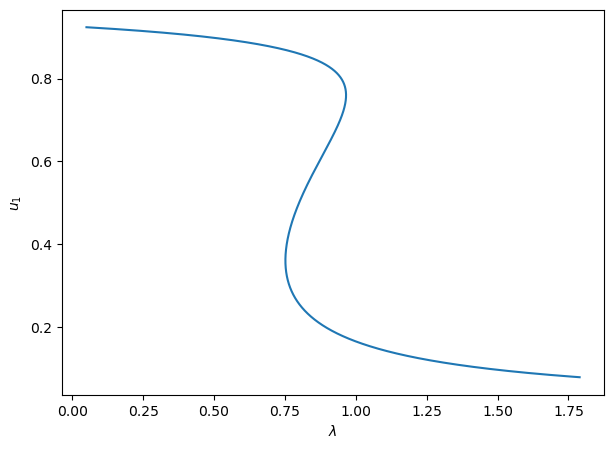

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from thermo_models.RaoultsLawModel import *
from distillation.DistillationModel import DistillationModel
from IPython.display import clear_output
from tqdm import tqdm
import ipywidgets as widgets
from IPython.display import display
from thermo_models.VLEEmpiricalModel import *
from scipy.misc import derivative as der
import math
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
import seaborn as sns

#Define empirical relationship
def xtoy(x):
    a, b = 9, -0.6
    y = a*x/(1+(a-1)*x) +b*x*(1 - x)
    return y

# Create a Raoult's law object
vle_model = VLEEmpiricalModelBinary(xtoy)
xD = 0.95
xB = 0.05
r = 0 # starting value
distillation_model = DistillationModel(vle_model, xF=np.array([0.5, 0.5]), xD=np.array([xD, 1 - xD]), xB=np.array([xB, 1 - xB]), reflux=r)

# u1 = x1, u2 = y1
def eqns(uvec, l):
    u1 = uvec[0]; u2 = uvec[1]
    res = np.zeros(2)

    res[0] = distillation_model.thermo_model.convert_x_to_y(np.array([u1, 1-u1]))[0][0] - u2
    res[1] = distillation_model.change_r(l).rectifying_step_xtoy(np.array([u1, u1-1]))[0] - u2
    
    return res

def eqns_aug(uvec, tau, ds, u0):
    l         = uvec[-1]
    res       = np.zeros_like(uvec)
    res[0:-1] = eqns(uvec[:-1], l)
    res[-1]   = ((uvec[0] - u0[0])*tau[0]) + ((uvec[1] - u0[1])*tau[1]) + ((uvec[2] - u0[2])*tau[2]) - ds

    return res

# ds = 0.00001
ds = 0.00001
lam_m1 = 0.05
old_sol_m1 = fsolve(eqns, x0=np.array([0.9, 0.1]), args=(lam_m1,))

lam_0 = lam_m1 + ds
old_sol = fsolve(eqns, x0=old_sol_m1, args=(lam_0,))

u1_sol = []
u2_sol = []
l_sol  = []

# for i in range(500000):
for i in range(500000):
    # Solve for tangent vector
    del_s       = math.sqrt(np.linalg.norm(lam_0 - lam_m1)**2)
    # Approximation from eqn 8 of Laing
    tau       = np.array([ (old_sol[0] - old_sol_m1[0])/del_s, (old_sol[1] - old_sol_m1[1])/del_s, (lam_0 - lam_m1)/del_s  ])

    prev_sol    = np.array([old_sol[0], old_sol[1], lam_0])
    new_sol     = fsolve(eqns_aug, x0 = prev_sol + ds*tau, args = (tau, ds, prev_sol))
    
    # Edit the variables that hold the two prior solutions
    lam_m1, lam_0 = lam_0, new_sol[-1]
    old_sol_m1 = np.copy(old_sol)
    old_sol    = np.copy(new_sol[:-1])

    if abs(lam_m1 - lam_0) > 1:
        break

    # Add solutions to a list
    u1_sol.append(old_sol[0])
    u2_sol.append(old_sol[1])
    l_sol.append(lam_0)

fig, ax = plt.subplots( figsize = (7,5))

ax.plot(l_sol, u1_sol)
ax.set_xlabel(r'$\lambda$')
ax.set_ylabel(r'$u_1$')
# plt.tight_layout()

plt.show()

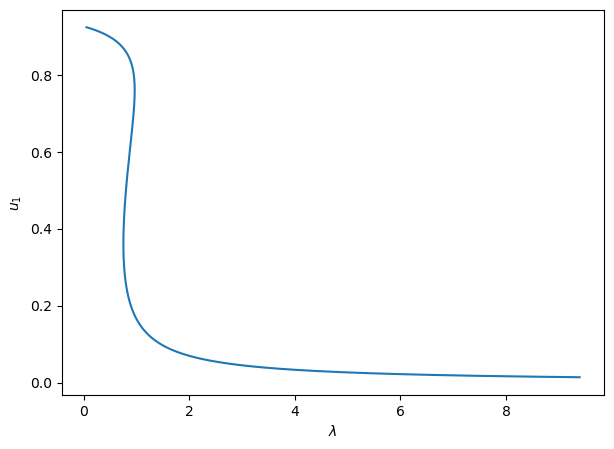

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from thermo_models.RaoultsLawModel import *
from distillation.DistillationModel import DistillationModel
from IPython.display import clear_output
from tqdm import tqdm
import ipywidgets as widgets
from IPython.display import display
from thermo_models.VLEEmpiricalModel import *
from scipy.misc import derivative as der
import math
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
import seaborn as sns

a, b = 9, -0.6

#Define empirical relationship
def xtoy(x):
    a, b = 9, -0.6
    y = a*x/(1+(a-1)*x) +b*x*(1 - x)
    return y

# Create a Raoult's law object
vle_model = VLEEmpiricalModelBinary(xtoy)
xD = 0.95
xB = 0.05
r = 0 # starting value
distillation_model = DistillationModel(vle_model, xF=np.array([0.5, 0.5]), xD=np.array([xD, 1 - xD]), xB=np.array([xB, 1 - xB]), reflux=r)

def df1du1(u1, u2, l):
    return (4*a*(u1**3)*b+(a**2)*(u1**2)*b+5*(u1**2)*b+2*a*u1*b+b-2*(a**2)*(u1**3)*b-2*(u1**3)*b-6*a*(u1**2)*b-4*u1*b+a)/(u1*(a-1)+1)**2
def df1du2(u1, u2, l):
    return -1
def df2du1(u1, u2, l):
    return 1/(l+1)
def df2du2(u1, u2, l):
    return -1
def df1dl(u1, u2, l):
    return 0
def df2dl(u1, u2, l):
    return (u1-xD)/(l+1)**2

# u1 = x1, u2 = y1
def eqns(uvec, l):
    u1 = uvec[0]; u2 = uvec[1]
    res = np.zeros(2)

    res[0] = distillation_model.thermo_model.convert_x_to_y(np.array([u1, 1-u1]))[0][0] - u2
    res[1] = distillation_model.change_r(l).rectifying_step_xtoy(np.array([u1, u1-1]))[0] - u2
    
    return res

def jac_eqns(uvec, l):
    u1 = uvec[0]; u2 = uvec[1]
    res = np.zeros((2,2))

    res[0,0] = df1du1(u1, u2, l)
    res[0,1] = df1du2(u1, u2, l)
    res[1,0] = df2du1(u1, u2, l)
    res[1,1] = df2du2(u1, u2, l)

    return res

def eqns_der(xvec, u1, u2, l):
    x1 = xvec[0]; x2 = xvec[1]; x3 = xvec[2]

    res = np.zeros(3)

    res[0] = df1du1(u1, u2, l)*x1 + df1du2(u1, u2, l)*x2 + df1dl(u1, u2, l)*x3
    res[1] = df2du1(u1, u2, l)*x1 + df2du2(u1, u2, l)*x2 + df2dl(u1, u2, l)*x3
    res[2] = (x1**2)  + (x2**2) + (x3**2) - 1

    return res
    
def eqns_aug(uvec, tau, ds, u0):
    l         = uvec[-1]
    res       = np.zeros_like(uvec)
    res[0:-1] = eqns(uvec[:-1], l)
    res[-1]   = ((uvec[0] - u0[0])*tau[0]) + ((uvec[1] - u0[1])*tau[1]) + ((uvec[2] - u0[2])*tau[2]) - ds

    return res

def jac_eqns_aug(uvec, der, ds, u0):
    u1 = uvec[0]; u2 = uvec[1];l = uvec[-1]
    res = np.zeros((3,3))

    res[0,0] = df1du1(u1, u2, l)
    res[0,1] = df1du2(u1, u2, l)
    res[0,2] = df1dl(u1, u2, l)

    res[1,0] = df2du1(u1, u2, l)
    res[1,1] = df2du2(u1, u2, l)
    res[1,2] = df2dl(u1, u2, l)

    res[2,0] = der[0]
    res[2,1] = der[1]
    res[2,2] = der[2]
        
    return res

ds = 0.001
lam_m1 = 0.05
old_sol_m1 = fsolve(eqns, x0=np.array([0.9, 0.1]), fprime=jac_eqns, args=(lam_m1,))

lam_0 = lam_m1 + ds
old_sol = fsolve(eqns, x0=old_sol_m1, fprime=jac_eqns, args=(lam_0,))

u1_sol = []
u2_sol = []
l_sol  = []

for i in range(10000):
    # Solve for tangent vector
    del_s       = math.sqrt(np.linalg.norm(lam_0 - lam_m1)**2)
    # Approximation from eqn 8 of Laing
    guess       = np.array([ (old_sol[0] - old_sol_m1[0])/del_s, (old_sol[1] - old_sol_m1[1])/del_s, (lam_0 - lam_m1)/del_s  ])
    tau = fsolve(eqns_der, guess, args = (old_sol[0], old_sol[1], lam_0))
    
    prev_sol    = np.array([old_sol[0], old_sol[1], lam_0])
    new_sol     = fsolve(eqns_aug, x0 = prev_sol + ds*tau, fprime=jac_eqns_aug, args = (tau, ds, prev_sol))
    
    # Edit the variables that hold the two prior solutions
    lam_m1, lam_0 = lam_0, new_sol[-1]
    old_sol_m1 = np.copy(old_sol)
    old_sol    = np.copy(new_sol[:-1])

    if abs(lam_m1 - lam_0) > 1:
        break

    # Add solutions to a list
    u1_sol.append(old_sol[0])
    u2_sol.append(old_sol[1])
    l_sol.append(lam_0)

fig, ax = plt.subplots( figsize = (7,5))

ax.plot(l_sol, u1_sol)
ax.set_xlabel(r'$\lambda$')
ax.set_ylabel(r'$u_1$')
# plt.tight_layout()

plt.show()